In [23]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import imp
import tensorflow as tf
import seaborn as sb


In [2]:
DATA_PATH = '/Users/Jamin/LocalData/ForceSMIP/'
MODEL_PATH = 'CanESM5/'


In [3]:
for ii, member_fn in enumerate(os.listdir(DATA_PATH + MODEL_PATH)):
    dm = xr.open_dataset(DATA_PATH + MODEL_PATH + member_fn)
    dm = dm.groupby("time.year").mean()

    if ii == 0:
        # add member dimension
        ds = dm.expand_dims(dim={"member": 1}, axis=0)
    else:
        print(ii)
        ds = xr.concat([ds, dm], dim="member")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [4]:
lat = ds.lat
lon = ds.lon
dA = ds['tos'].values
dF = np.stack(dA.shape[0]*[ds['tos'].mean(dim=["member"]).values])
dI = dA - dF

In [7]:
dA.shape

(25, 143, 72, 144)

In [42]:
Xtrain_us = dA[:20,...].reshape(-1, len(lat), len(lon))
Xval_us = dA[20:,...].reshape(-1, len(lat), len(lon))

Ttrain_us = dI[:20,...].reshape(-1, len(lat), len(lon))
Tval_us = dI[20:,...].reshape(-1, len(lat), len(lon))

Ftrain_us = dF[:20,...].reshape(-1, len(lat), len(lon))
Fval_us = dF[20:,...].reshape(-1, len(lat), len(lon))

t_mean = np.nanmean(Ttrain_us)
t_std = np.nanstd(Ttrain_us)

f_mean = np.nanmean(Ftrain_us)
f_std = np.nanstd(Ftrain_us)

# normalize
Xtrain = (Xtrain_us - np.nanmean(Xtrain_us, axis=(1,2))[:,None, None])/np.nanstd(Xtrain_us, axis=(1,2))[:,None, None]
Xval = (Xval_us - np.nanmean(Xval_us, axis=(1,2))[:,None, None])/np.nanstd(Xval_us, axis=(1,2))[:,None, None]

Ttrain = (Ttrain_us - t_mean)/t_std
Tval = (Tval_us - t_mean)/t_std

Ftrain = (Ftrain_us - f_mean)/f_std
Fval = (Fval_us - f_mean)/f_std

Xtrain = np.nan_to_num(Xtrain)
Xval = np.nan_to_num(Xval)
Ttrain = np.nan_to_num(Ttrain)
Tval = np.nan_to_num(Tval)
Ftrain = np.nan_to_num(Ftrain)
Fval = np.nan_to_num(Fval)

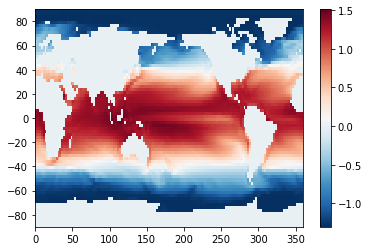

In [44]:
plt.pcolormesh(lon,lat, Xtrain[0], cmap = 'RdBu_r')
plt.colorbar()
plt.show()
# plt.pcolormesh(lon,lat, Ttrain[0], cmap = 'RdBu_r')
# plt.colorbar()
# plt.show()
# plt.pcolormesh(lon,lat, Ftrain[0], cmap = 'RdBu_r')
# plt.colorbar()
# plt.show()

# plt.pcolormesh(lon,lat, Xval[0], cmap = 'RdBu_r')
# plt.colorbar()
# plt.show()
# plt.pcolormesh(lon,lat, Tval[0], cmap = 'RdBu_r')
# plt.colorbar()
# plt.show()
# plt.pcolormesh(lon,lat, Fval[0], cmap = 'RdBu_r')
# plt.colorbar()
# plt.show()

In [90]:
import VED
imp.reload(VED)

<module 'VED' from '/Users/Jamin/Library/CloudStorage/GoogleDrive-jaminrader.science@gmail.com/My Drive/2023/ForceSMIP/ForceSMIP/VED.py'>

In [175]:
settings = { 
    'encoding_nodes' : [20, 20, 10],
    'code_nodes' : 10,
    'activation' : 'elu',
    'seed' : 0,  
    'variational_loss' : .0001,
    'learning_rate' : .001
}

In [176]:
tf.random.set_seed(settings['seed'])
ved, encoder, decoder = VED.build_VED(Xtrain, settings)

In [177]:
optimizer = tf.keras.optimizers.Adam(learning_rate=settings['learning_rate'])
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=50, # if loss doesn’t decrease for 50 epochs...
)

ved.compile(loss = "mse", optimizer = optimizer)

In [178]:
ved.fit(Ttrain, Ttrain,
          epochs = 300,
          validation_data = (Xval, Xval),
          callbacks=[early_stopping])

Epoch 1/300
90/90 [==============================] - 1s 3ms/step - loss: 0.6824 - val_loss: 0.6363
Epoch 2/300
90/90 [==============================] - 0s 3ms/step - loss: 0.6084 - val_loss: 0.6443
Epoch 3/300
90/90 [==============================] - 0s 4ms/step - loss: 0.6000 - val_loss: 0.6499
Epoch 4/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5978 - val_loss: 0.6494
Epoch 5/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5968 - val_loss: 0.6410
Epoch 6/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5953 - val_loss: 0.6436
Epoch 7/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5831 - val_loss: 0.6513
Epoch 8/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5750 - val_loss: 0.6654
Epoch 9/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5710 - val_loss: 0.6739
Epoch 10/300
90/90 [==============================] - 0s 3ms/step - loss: 0.5675 - val_loss: 0.6751
Epoch 11/

In [179]:
Ptrain = ved.predict(Ttrain)
Pval = ved.predict(Tval)

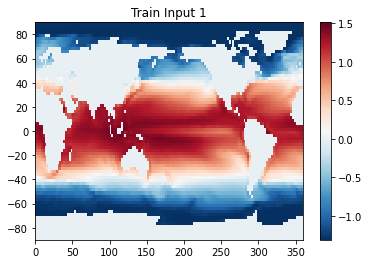

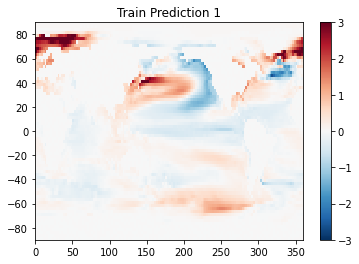

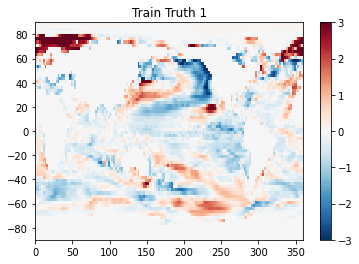

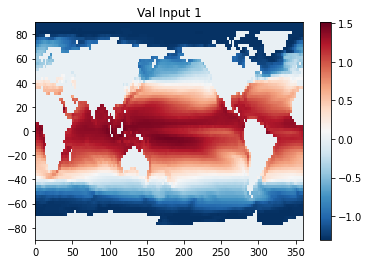

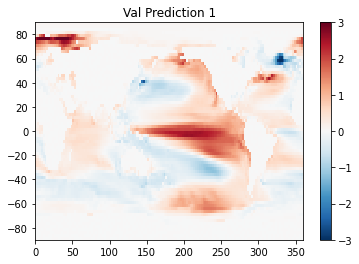

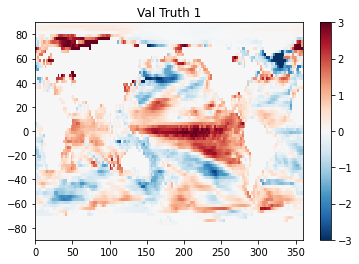

In [180]:
isample = 1

plt.pcolormesh(lon,lat, Xtrain[isample], cmap = 'RdBu_r')
plt.colorbar()
plt.title('Train Input ' + str(isample))
plt.show()
plt.pcolormesh(lon,lat, Ptrain[isample], cmap = 'RdBu_r', vmin = -3, vmax = 3)
plt.colorbar()
plt.title('Train Prediction ' + str(isample))
plt.show()
plt.pcolormesh(lon,lat, Ttrain[isample], cmap = 'RdBu_r', vmin = -3, vmax = 3)
plt.colorbar()
plt.title('Train Truth ' + str(isample))
plt.show()

plt.pcolormesh(lon,lat, Xval[isample], cmap = 'RdBu_r')
plt.colorbar()
plt.title('Val Input ' + str(isample))
plt.show()
plt.pcolormesh(lon,lat, Pval[isample], cmap = 'RdBu_r', vmin = -3, vmax = 3)
plt.colorbar()
plt.title('Val Prediction ' + str(isample))
plt.show()
plt.pcolormesh(lon,lat, Tval[isample], cmap = 'RdBu_r', vmin = -3, vmax = 3)
plt.colorbar()
plt.title('Val Truth ' + str(isample))
plt.show()

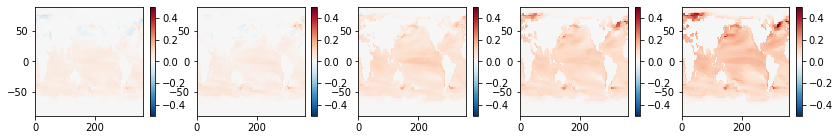

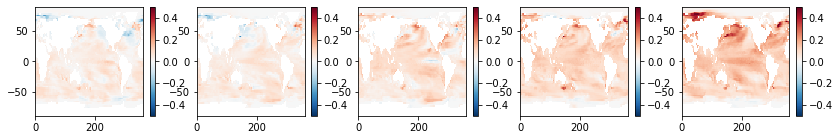

In [115]:
# Print a timeseries of actual forced response
# 5 maps of validation from 40, 30, 20, 10, and 0 years before the end of the simulation
plt.figure(figsize=(14,2))
for iplot, Fmap in enumerate(Fval[-41::10]):
    ax = plt.subplot(1,5,iplot+1)
    plt.pcolormesh(lon,lat, Fmap - Fval[0], cmap = 'RdBu_r', vmax = .5, vmin = -.5)
    plt.colorbar()

plt.figure(figsize=(14,2))
for iplot, imap in enumerate(np.arange(-41,0,10)):
    Xmap = Xval_us[imap]
    Pmap = Pval[imap] * t_std + t_mean
    ax = plt.subplot(1,5,iplot+1)
    plot_map = ((Xmap - Pmap) - f_mean)/f_std
    plt.pcolormesh(lon,lat, plot_map - Fval[0], cmap = 'RdBu_r', vmax = .5, vmin = -.5)
    plt.colorbar()